In [ ]:
import gzip
import json
import pandas as pd
from tqdm import tqdm
import glob
import os

# Process data

In [ ]:
def process_and_save_reviews(chunk_size=50000):
    """
    Process and save the data in smaller chunks to manage memory
    """
    path = "Electronics.jsonl.gz"
    chunk_counter = 0
    chunk = []
    
    # First count total lines
    print("Counting total lines...")
    with gzip.open(path, 'rt', encoding="utf8") as f:
        total_lines = sum(1 for _ in f)
    
    print(f"Processing {total_lines:,} reviews in chunks of {chunk_size:,}")
    
    # Process in chunks
    with gzip.open(path, 'rt', encoding="utf8") as f:
        for i, line in tqdm(enumerate(f), total=total_lines):
            d = json.loads(line.strip())
            processed_review = {
                'user_id': d['user_id'],
                'rating': int(float(d['rating'])),
                'helpful_vote': int(d['helpful_vote']),
                'timestamp': int(d['timestamp']),
                'asin': d['asin'],
                'text': d['text'],
                'title': d.get('title', ''),
                'parent_asin': d.get('parent_asin', ''),
                'verified_purchase': d['verified_purchase']
            }
            chunk.append(processed_review)
            
            # Save chunk when it reaches the chunk_size
            if len(chunk) >= chunk_size:
                df = pd.DataFrame(chunk)
                df.to_parquet(f'chunks/chunk_{chunk_counter}.parquet')
                chunk = []  # Clear chunk
                chunk_counter += 1
                
    # Save any remaining reviews
    if chunk:
        df = pd.DataFrame(chunk)
        df.to_parquet(f'chunk_{chunk_counter}.parquet')
    
    print(f"Processing complete! Saved {chunk_counter + 1} chunks.")

# Run the processing
process_and_save_reviews()

In [ ]:
# Get all chunk files from the chunks folder
chunks = glob.glob('chunks/chunk_*.parquet')
# Load and combine all chunks
df = pd.concat([pd.read_parquet(f) for f in chunks])

In [15]:
def filter_chunks(percent=1):
    """
    Load chunks, apply filters, and create balanced sample
    """
    print("Loading and filtering chunks...")
    chunks = [f for f in sorted(os.listdir('chunks')) if f.endswith('.parquet')]
    print(f"Found {len(chunks)} parquet files")
    
    # First pass: count and filter
    rating_counts = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
    total_reviews = 0
    filtered_chunks = []
    
    # Process all chunks
    for chunk_file in tqdm(chunks, desc="Processing chunks"):
        df = pd.read_parquet(os.path.join('chunks', chunk_file))
        total_reviews += len(df)
        
        df['date'] = pd.to_datetime(df['timestamp'], unit='ms')
        filtered_df = df[
            (df['date'].dt.year >= 2004) &  # Filter out reviews before 2004
            (df['text'].str.len() >= 20) &   # Filter out reviews with less than 20 characters
            (df['text'].str.len() <= 3520) &  # Filter out reviews with more than 3520 characters
            (df['verified_purchase'] == True)  # Filter out unverified purchases
        ]
        
        for rating in range(1, 6):
            rating_counts[rating] += len(filtered_df[filtered_df['rating'] == rating])
            
        filtered_chunks.append(filtered_df)
    
    # Combine filtered chunks
    print("Combining filtered chunks...")
    combined_df = pd.concat(filtered_chunks, ignore_index=True)
    
    # Sample 1% with equal distribution
    print("\nSampling balanced dataset...")
    target_total = int(total_reviews * (percent/100))
    sample_size_per_rating = target_total // 5
    
    final_samples = []
    for rating in range(1, 6):
        rating_data = combined_df[combined_df['rating'] == rating]
        if len(rating_data) >= sample_size_per_rating:
            sampled = rating_data.sample(n=sample_size_per_rating, random_state=42)
            final_samples.append(sampled)
        else:
            print(f"Warning: Only {len(rating_data)} reviews available for rating {rating}")
            final_samples.append(rating_data)
    
    final_df = pd.concat(final_samples, ignore_index=True)
    
    # Print statistics
    print("\nFiltering Results:")
    print(f"Total initial reviews: {total_reviews:,}")
    print("\nReviews per rating after filtering:")
    for rating, count in rating_counts.items():
        print(f"Rating {rating}: {count:,}")
    
    print("\nFinal sampled dataset:")
    print(final_df['rating'].value_counts().sort_index())
    
    # Save processed dataset
    final_df.to_parquet('processed_balanced.parquet')
    
    return final_df

# Run filtering
filtered_df = filter_chunks(percent=1)

Loading and filtering chunks...
Found 878 parquet files


Processing chunks: 100%|██████████| 878/878 [02:52<00:00,  5.08it/s]


Combining filtered chunks...

Sampling balanced dataset...

Filtering Results:
Total initial reviews: 43,886,944

Reviews per rating after filtering:
Rating 1: 4,577,077
Rating 2: 1,968,106
Rating 3: 2,498,497
Rating 4: 4,589,194
Rating 5: 22,433,872

Final sampled dataset:
rating
1    87773
2    87773
3    87773
4    87773
5    87773
Name: count, dtype: int64


# Exploratory analysis

Loading data...
Loaded 438,865 reviews

Basic Statistics:
count    438865.000000
mean          3.000000
std           1.414215
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64


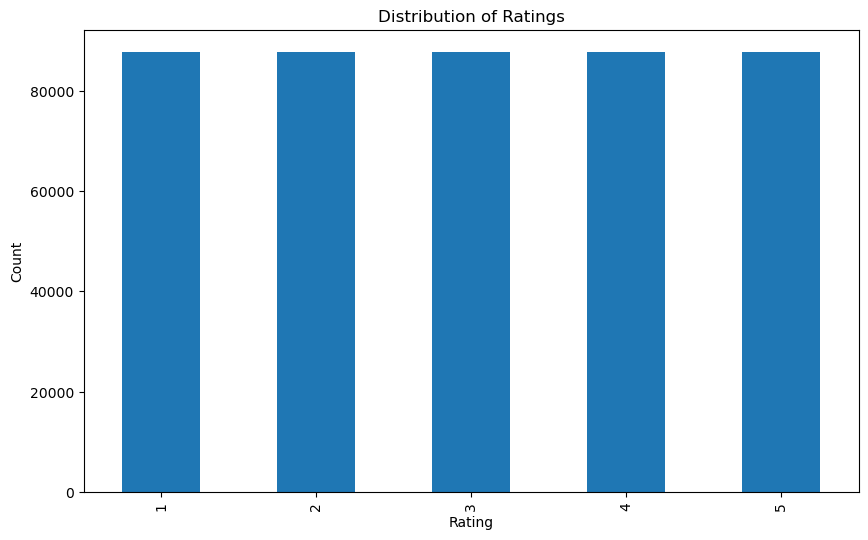

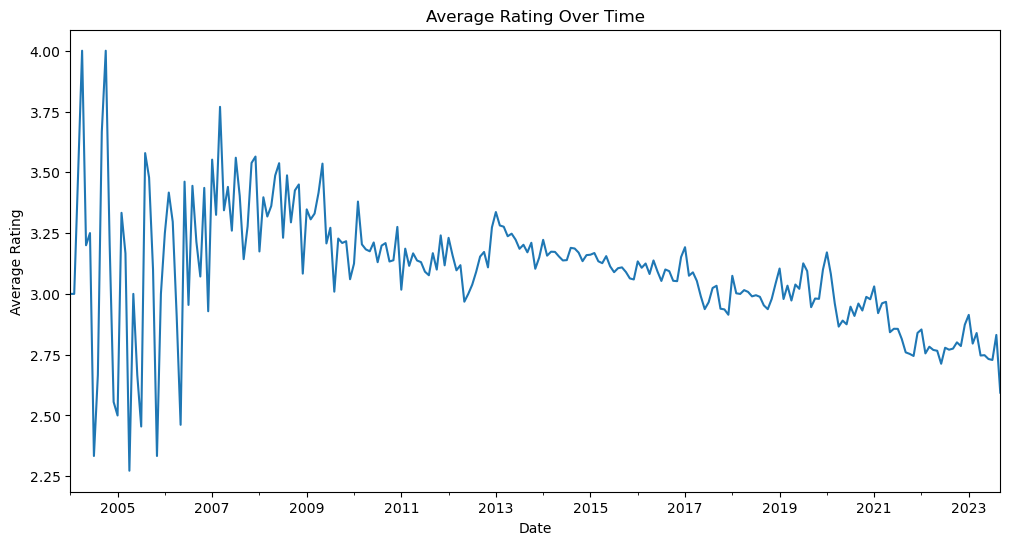


Helpful Votes Statistics:
count    438865.000000
mean          1.172192
std          31.291368
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max       18501.000000
Name: helpful_vote, dtype: float64

Average Rating by Verified Purchase:
verified_purchase
True    3.0
Name: rating, dtype: float64

User Review Statistics:
count    423823.000000
mean          1.035491
std           0.208995
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          10.000000
Name: count, dtype: float64


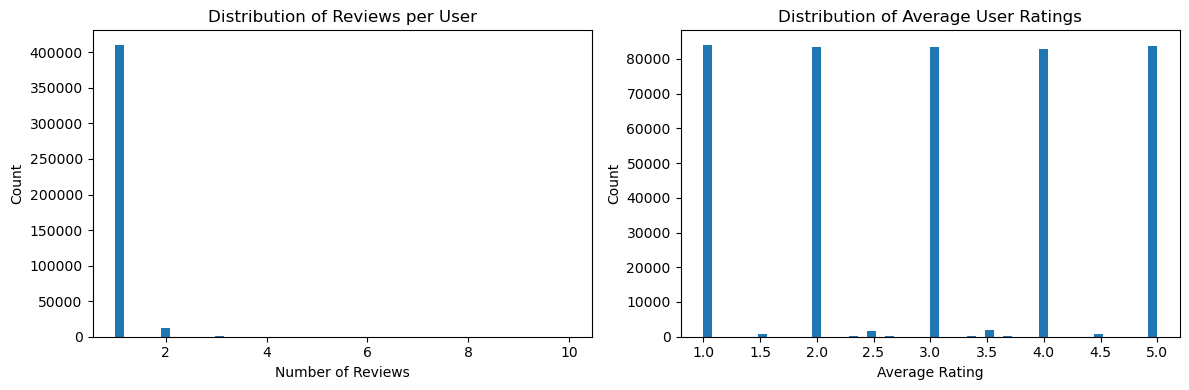

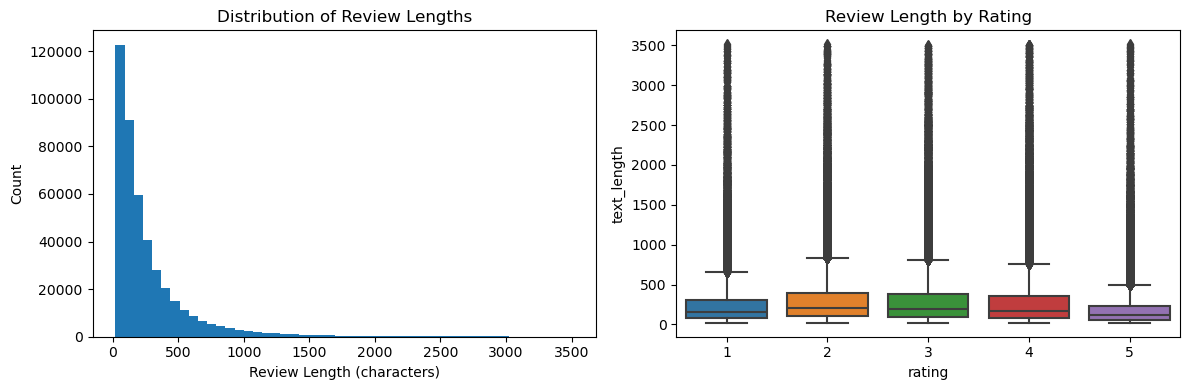


Text Length Statistics:
count    438865.000000
mean        278.818985
std         348.055441
min          20.000000
25%          81.000000
50%         165.000000
75%         334.000000
max        3514.000000
Name: text_length, dtype: float64

Correlation between review length and helpful votes: 0.065


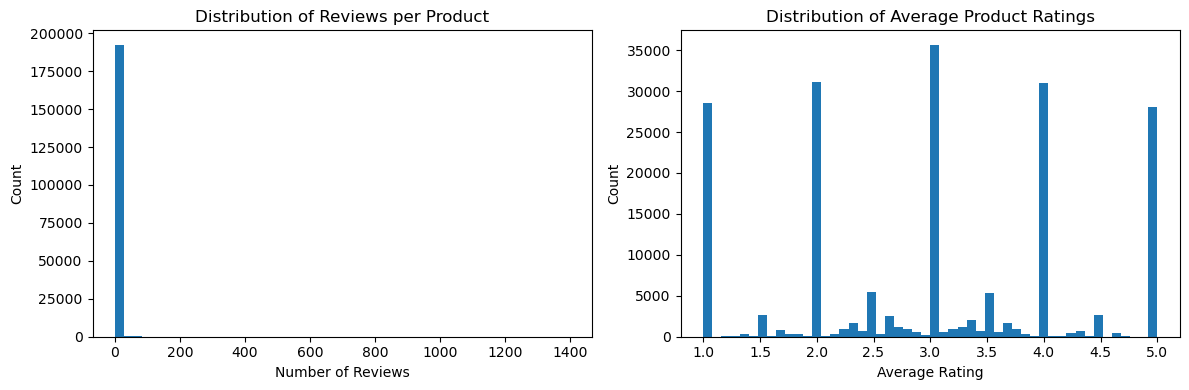


Product Statistics:
Total unique products: 193260

Reviews per product:
count    193260.000000
mean          2.270853
std           7.744574
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        1397.000000
Name: count, dtype: float64


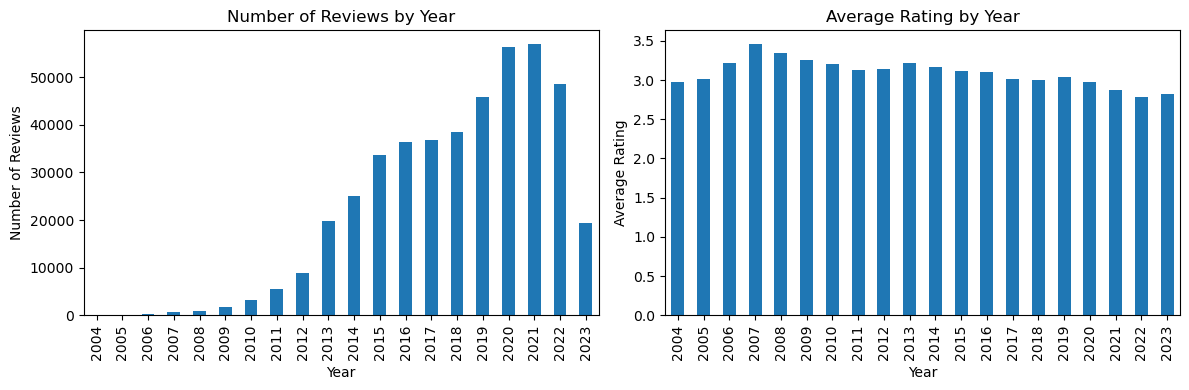


Verified Purchase Analysis:
                   rating            helpful_vote text_length
                    count mean   std         mean        mean
verified_purchase                                            
True               438865  3.0  1.41         1.17      278.82

Overall Summary Statistics:
Total Reviews: 438865.00
Unique Users: 423823.00
Unique Products: 193260.00
Average Rating: 3.00
Median Rating: 3.00
Average Review Length: 278.82
Verified Purchase %: 0.00
Average Helpful Votes: 1.17


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# Load all chunks from the chunks folder
print("Loading data...")
df = pd.read_parquet('processed_balanced.parquet')
print(f"Loaded {len(df):,} reviews")

# The rest of your analysis code remains the same, just remove the DataFrame conversion
# since we already have a DataFrame

# Basic statistics
print("\nBasic Statistics:")
print(df['rating'].describe())

# Rating distribution
plt.figure(figsize=(10, 6))
df['rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Average rating over time
df['date'] = pd.to_datetime(df['timestamp'], unit='ms')
monthly_ratings = df.groupby(df['date'].dt.to_period('M'))['rating'].mean()
plt.figure(figsize=(12, 6))
monthly_ratings.plot(kind='line')
plt.title('Average Rating Over Time')
plt.xlabel('Date')
plt.ylabel('Average Rating')
plt.show()

# Helpful votes analysis
print("\nHelpful Votes Statistics:")
print(df['helpful_vote'].describe())

# Verified vs unverified purchase ratings
print("\nAverage Rating by Verified Purchase:")
print(df.groupby('verified_purchase')['rating'].mean())

# User Analysis
user_review_counts = df['user_id'].value_counts()
user_avg_ratings = df.groupby('user_id')['rating'].mean()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(user_review_counts, bins=50)
plt.title('Distribution of Reviews per User')
plt.xlabel('Number of Reviews')
plt.ylabel('Count')
print("\nUser Review Statistics:")
print(user_review_counts.describe())

plt.subplot(1, 2, 2)
plt.hist(user_avg_ratings, bins=50)
plt.title('Distribution of Average User Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Review Text Analysis
df['text_length'] = df['text'].str.len()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(df['text_length'], bins=50)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length (characters)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.boxplot(x='rating', y='text_length', data=df)
plt.title('Review Length by Rating')
plt.tight_layout()
plt.show()

print("\nText Length Statistics:")
print(df['text_length'].describe())

# Correlation between text length and helpful votes
correlation = df['text_length'].corr(df['helpful_vote'])
print(f"\nCorrelation between review length and helpful votes: {correlation:.3f}")

# Product Analysis
product_review_counts = df['asin'].value_counts()
product_avg_ratings = df.groupby('asin')['rating'].mean()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(product_review_counts, bins=50)
plt.title('Distribution of Reviews per Product')
plt.xlabel('Number of Reviews')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(product_avg_ratings, bins=50)
plt.title('Distribution of Average Product Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

print("\nProduct Statistics:")
print(f"Total unique products: {df['asin'].nunique()}")
print("\nReviews per product:")
print(product_review_counts.describe())

# Time analysis
df['year'] = df['date'].dt.year
yearly_counts = df.groupby('year').size()
yearly_ratings = df.groupby('year')['rating'].mean()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
yearly_counts.plot(kind='bar')
plt.title('Number of Reviews by Year')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')

plt.subplot(1, 2, 2)
yearly_ratings.plot(kind='bar')
plt.title('Average Rating by Year')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.tight_layout()
plt.show()

# Verified Purchase Analysis
verified_stats = df.groupby('verified_purchase').agg({
    'rating': ['count', 'mean', 'std'],
    'helpful_vote': 'mean',
    'text_length': 'mean'
}).round(2)

print("\nVerified Purchase Analysis:")
print(verified_stats)

# Overall Summary Statistics
summary_stats = {
    'Total Reviews': len(df),
    'Unique Users': df['user_id'].nunique(),
    'Unique Products': df['asin'].nunique(),
    'Average Rating': df['rating'].mean(),
    'Median Rating': df['rating'].median(),
    'Average Review Length': df['text_length'].mean(),
    'Verified Purchase %': (df['verified_purchase'] == 'Y').mean() * 100,
    'Average Helpful Votes': df['helpful_vote'].mean()
}

print("\nOverall Summary Statistics:")
for key, value in summary_stats.items():
    print(f"{key}: {value:.2f}")